In [1]:
# Cell 1: imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestClassifier

from scipy.sparse import hstack, csr_matrix

# SHAP
import shap

# Utility
import joblib  # for saving/loading models and transformers


In [2]:
# Cell 2: preprocessing function that returns processed sparse matrix, transformers, and feature names
def preprocess_return_names(df, cat_cols=None, fit_imputer=None, fit_scaler=None, fit_ohe=None):
    """
    Input:
      - df: pandas DataFrame features (no target)
      - cat_cols: list of categorical columns to encode (if None, default list used)
      - fit_*: optional fitted transformers to use for transform (if provided)
    Returns:
      - X_sparse: scipy csr_matrix (numeric scaled + ohe sparse)
      - imputer, scaler, ohe : fitted transformers (or those passed in)
      - feature_names: list of names corresponding to columns in the combined matrix (order matters)
      - num_cols: list of numeric column names used
    """
    df = df.copy()
    if cat_cols is None:
        cat_cols = ['device_id', 'source', 'browser', 'sex', 'country']
    cat_cols = [c for c in cat_cols if c in df.columns]
    
    # drop identifiers / raw ip strings
    drop_cols = ['user_id', 'ip_address']
    for c in drop_cols:
        if c in df.columns:
            df.drop(columns=c, inplace=True)
    
    # Convert datetime columns to unix seconds (if exist)
    datetime_cols = ['purchase_time', 'signup_time', 'prev_purchase_time']
    for col in datetime_cols:
        if col in df.columns:
            # if fully null -> fill 0; otherwise convert
            if df[col].isnull().all():
                df[col] = 0
            else:
                df[col] = pd.to_datetime(df[col], errors='coerce')
                # convert to int seconds; use astype then fillna
                df[col] = df[col].astype('int64') // 10**9
                df[col] = df[col].fillna(0).astype(int)
    
    # numeric columns (after dropping categorical)
    num_cols = df.select_dtypes(include=[np.number]).columns.tolist()
    num_cols = [c for c in num_cols if c not in cat_cols]
    
    # Drop fully-missing numeric columns (can't impute median)
    fully_missing_num_cols = [col for col in num_cols if df[col].isnull().all()]
    if fully_missing_num_cols:
        print("Dropped fully-missing numeric columns:", fully_missing_num_cols)
        df.drop(columns=fully_missing_num_cols, inplace=True)
        num_cols = [c for c in num_cols if c not in fully_missing_num_cols]
    
    # Impute numeric
    if fit_imputer is None:
        imputer = SimpleImputer(strategy='median')
        numeric_array = imputer.fit_transform(df[num_cols])
    else:
        imputer = fit_imputer
        numeric_array = imputer.transform(df[num_cols])
    
    # Fill categorical missing values
    for c in cat_cols:
        df[c] = df[c].fillna('missing')
    
    # OneHotEncode categorical to sparse
    if fit_ohe is None:
        # newer sklearn uses sparse_output; we'll set it True
        ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=True)
        ohe_matrix = ohe.fit_transform(df[cat_cols])
    else:
        ohe = fit_ohe
        ohe_matrix = ohe.transform(df[cat_cols])
    
    # Scale numeric
    if fit_scaler is None:
        scaler = StandardScaler()
        scaled_numeric = scaler.fit_transform(numeric_array)
    else:
        scaler = fit_scaler
        scaled_numeric = scaler.transform(numeric_array)
    
    # Convert numeric to sparse and hstack
    numeric_sparse = csr_matrix(scaled_numeric)
    X_sparse = hstack([numeric_sparse, ohe_matrix], format='csr')
    
    # Build feature names: numeric first, then ohe feature names
    try:
        ohe_feature_names = list(ohe.get_feature_names_out(cat_cols))
    except Exception:
        # fallback in case older sklearn
        ohe_feature_names = [f"{c}_{v}" for c in cat_cols for v in ohe.categories_[cat_cols.index(c)]]
    feature_names = list(num_cols) + ohe_feature_names
    
    return X_sparse, imputer, scaler, ohe, feature_names, num_cols


In [3]:
# Cell 3: Load data, split, preprocess, train RF (or load saved model) with sampling

df = pd.read_csv('../data/Fraud_Data_processed.csv')

# Target column name
target = 'class' 

# Separate features (X) and target (y)
X = df.drop(columns=[target])
y = df[target]

# Split dataset into train and test sets with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Sample smaller subset from training data to reduce memory usage
sample_size = 10000  # adjust based on your system's memory
if X_train.shape[0] > sample_size:
    X_train_sample = X_train.sample(n=sample_size, random_state=42)
    y_train_sample = y_train.loc[X_train_sample.index]
else:
    X_train_sample = X_train
    y_train_sample = y_train

# Preprocess training sample: fit imputers, scalers, encoders
X_train_sp, imputer, scaler, ohe, feature_names, num_cols = preprocess_return_names(X_train_sample)

# Preprocess test data with fitted preprocessing objects (no refit)
X_test_sp, _, _, _, _, _ = preprocess_return_names(
    X_test, fit_imputer=imputer, fit_scaler=scaler, fit_ohe=ohe
)

print("Shapes (sparse):", X_train_sp.shape, X_test_sp.shape)
print("Number of features:", len(feature_names))

# Train RandomForest classifier with balanced class weights and all CPU cores
rf = RandomForestClassifier(
    n_estimators=200, class_weight='balanced', random_state=42, n_jobs=-1
)
rf.fit(X_train_sp, y_train_sample)  

# Save model and preprocessing objects for later use
joblib.dump(rf, 'rf_task2_sample.pkl')
joblib.dump(
    {'imputer': imputer, 'scaler': scaler, 'ohe': ohe, 'feature_names': feature_names, 'num_cols': num_cols},
    'preproc_task2_sample.joblib'
)

print("Random Forest trained on sampled data and saved.")


Dropped fully-missing numeric columns: ['time_since_prev_purchase']
Dropped fully-missing numeric columns: ['time_since_prev_purchase']
Shapes (sparse): (10000, 9956) (30223, 9956)
Number of features: 9956
Random Forest trained on sampled data and saved.


In [6]:
bg_sample_size = 500
if X_train_sp.shape[0] > bg_sample_size:
    bg_idx = np.random.choice(X_train_sp.shape[0], size=bg_sample_size, replace=False)
else:
    bg_idx = np.arange(X_train_sp.shape[0])

X_train_bg_dense = X_train_sp[bg_idx].toarray()

explainer = shap.TreeExplainer(rf, X_train_bg_dense, feature_perturbation="interventional")

eval_size = 200
eval_idx = np.random.choice(X_test_sp.shape[0], size=min(eval_size, X_test_sp.shape[0]), replace=False)
X_eval_sp = X_test_sp[eval_idx]
X_eval_dense = X_eval_sp.toarray()

# Pass check_additivity=False here
shap_vals = explainer.shap_values(X_eval_dense, check_additivity=False)

if isinstance(shap_vals, (list, tuple)):
    shap_vals_pos = shap_vals[1]
else:
    shap_vals_pos = shap_vals

print("SHAP values computed for evaluation sample:", shap_vals_pos.shape)


100%|===================| 398/400 [01:23<00:00]        

SHAP values computed for evaluation sample: (200, 9956, 2)


shap_vals_pos shape: (200, 9956, 2)
Top features by mean |SHAP|:
 time_since_signup          0.030434
purchase_time              0.028293
signup_time                0.016473
ip_int                     0.002965
ip_address_numeric         0.002918
hour_of_day                0.002579
day_of_week                0.002562
device_id_ZEDBQUMSPQOKD    0.002165
purchase_value             0.002125
age                        0.002030
avg_purchase_value         0.001808
device_id_XMIIMMECPYEAW    0.001602
device_id_FSPSQIDVJCIPA    0.001556
source_Ads                 0.001550
source_SEO                 0.001387
sex_F                      0.001378
sex_M                      0.001281
browser_Chrome             0.001249
country_United States      0.001181
source_Direct              0.001165
dtype: float64


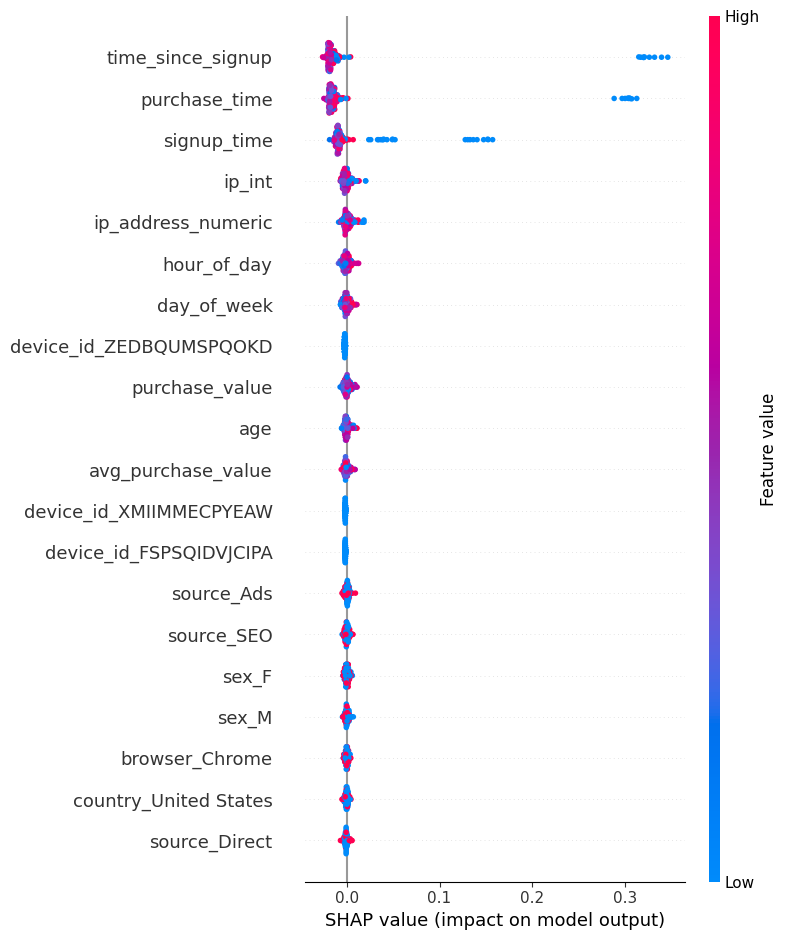

In [8]:
print("shap_vals_pos shape:", shap_vals_pos.shape)  # debug

# If 3D (samples, features, classes), reduce to 2D by selecting class 1 (or mean)
if shap_vals_pos.ndim == 3:
    shap_vals_pos = shap_vals_pos[:, :, 1]  # take class 1 shap values

mean_abs_shap = np.mean(np.abs(shap_vals_pos), axis=0)  # shape (num_features,)

feature_importance = pd.Series(mean_abs_shap, index=feature_names).sort_values(ascending=False)

top_k = 20
top_features = feature_importance.head(top_k).index.tolist()
print("Top features by mean |SHAP|:\n", feature_importance.head(top_k))

top_indices = [feature_names.index(f) for f in top_features]
X_eval_top = X_eval_dense[:, top_indices]
shap_vals_top = shap_vals_pos[:, top_indices]
top_feature_names = [feature_names[i] for i in top_indices]

plt.figure(figsize=(8, 6))
shap.summary_plot(shap_vals_top, X_eval_top, feature_names=top_feature_names, show=True)


<Figure size 600x400 with 0 Axes>

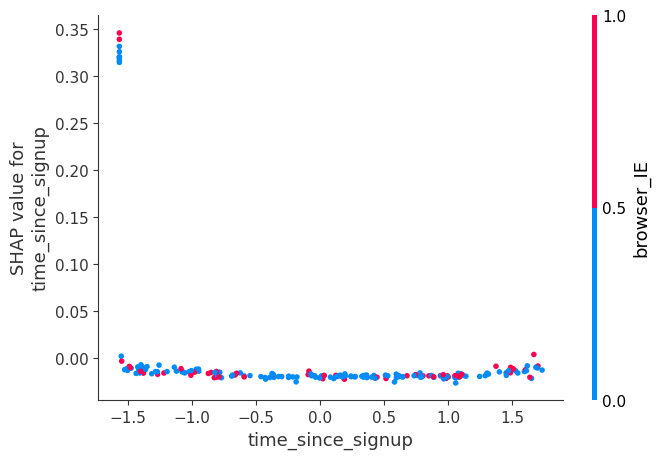

<Figure size 600x400 with 0 Axes>

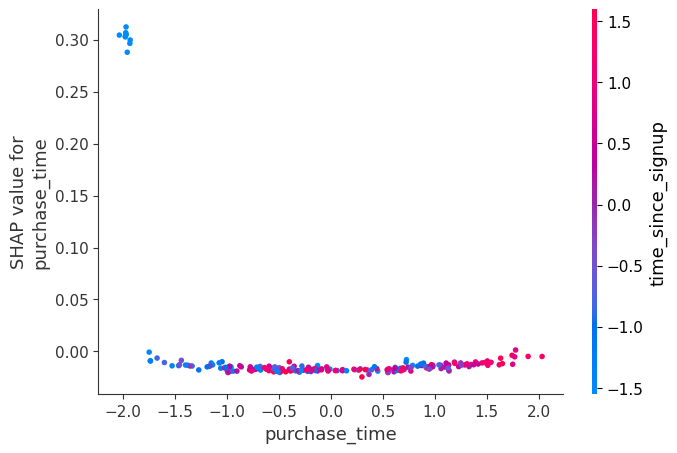

<Figure size 600x400 with 0 Axes>

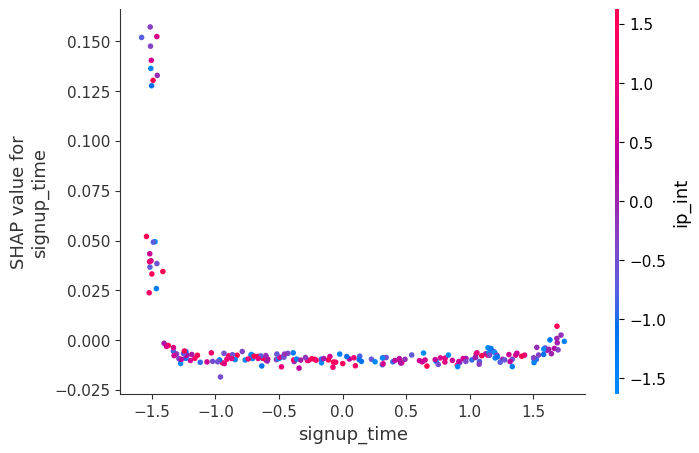

In [9]:
# Cell 6: Dependence plots for top features (use original dense eval data but select feature index)
# We'll plot dependence for the top 3 features
for feat in top_features[:3]:
    idx = feature_names.index(feat)
    # shap.dependence_plot accepts shap_values and the full X (dense) and feature index or name
    # provide the full X_eval_dense and full shap_vals_pos, but specify feature=idx
    plt.figure(figsize=(6,4))
    shap.dependence_plot(idx, shap_vals_pos, X_eval_dense, feature_names=feature_names, show=True)


In [10]:
# Cell 7: Local explanation — Force plot for a single example
instance_i = 0
instance = X_eval_dense[instance_i:instance_i+1]
instance_shap = shap_vals_pos[instance_i]

# Show force plot in notebook (requires JS)
shap.initjs()
force_html = shap.force_plot(explainer.expected_value[1] if isinstance(explainer.expected_value, np.ndarray) else explainer.expected_value,
                            instance_shap, instance, feature_names=feature_names, matplotlib=False)

# Save to html file so you can open in browser
shap.save_html("shap_force_plot_instance.html", force_html)
print("Force plot saved to shap_force_plot_instance.html. Open this file in a browser to view the interactive force plot.")


Force plot saved to shap_force_plot_instance.html. Open this file in a browser to view the interactive force plot.
